In [1]:
# Instala o banco de dados vetorial ChromaDB
!pip install chromadb

In [2]:
# Instala a biblioteca que possibilita a manipulação de LLMs
!pip install -U sentence-transformers

In [18]:
%load_ext cudf.pandas
import pandas as pd
import networkx as nx
import chromadb
from sentence_transformers import SentenceTransformer


ModuleNotFoundError: No module named 'cudf'

1) Os dados disponibilizados representam notícias coletados pela agência. Inicialmente estes devem ser carregados e pré-processados, por exemplo, eliminado o conteúdo "\n" do corpo de texto de cada notícia. Ou outro pré-processamento que seja requerido. Os dados de todos os arquivos disponibilizados devem ser carregados;


In [2]:
#url do dataset completo: https://github.com/fergiemcdowall/reuters-21578-json/tree/master/data/full
# O campo body deve passar por um pré-processamento alterando \n por espaço

import os 
import json

'''
file_name = '/workspaces/DataScience_class/atividades/Avaliacao II/reuters-000.json'

import json

data = json.load(open(file_name, "r"))
df_list = list()
for item in data:
  df_list.append(item)

df = pd.DataFrame(df_list)
df
'''
def json_files(get_path = None):
    #Substitua path pela sua pasta onde estão os arquivos json
    path = get_path
    list_paths = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.json'):
                list_paths.append(os.path.join(root, file))

    # Criando um dataframe vazio
    df = pd.DataFrame()
    list_paths.sort()
    # Loop para carregar os arquivos json e concatenar no dataframe
    for path in list_paths:
        # Carregando o arquivo json
        data = json.load(open(path, "r"))

        # Criando um dataframe com o arquivo json
        df_list = list()
        for item in data:
            df_list.append(item)
        df_temp = pd.DataFrame(df_list)
        # Concatenando o dataframe criado com os dataframes anteriores
        df = pd.concat([df, df_temp], ignore_index=True)
    return df

df = json_files("/workspaces/DataScience_class/atividades/Avaliacao II")
df.head()


,title,body,date,topics,places,id,organisations
0,BAHIA COCOA REVIEW,Showers continued throughout the week in\nthe ...,26-FEB-1987 15:01:01.79,[cocoa],"[el-salvador, usa, uruguay]",1,NaN
1,STANDARD OIL <SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America\nInc said...,26-FEB-1987 15:02:20.00,NaN,[usa],2,NaN
2,TEXAS COMMERCE BANCSHARES <TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas\nCommerc...,26-FEB-1987 15:03:27.51,NaN,[usa],3,NaN
3,TALKING POINT/BANKAMERICA <BAC> EQUITY OFFER,BankAmerica Corp is not under\npressure to act...,26-FEB-1987 15:07:13.72,NaN,"[usa, brazil]",4,NaN
4,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department\nreported the ...,26-FEB-1987 15:10:44.60,"[grain, wheat, corn, barley, oat, sorghum]",[usa],5,NaN


In [3]:
#!pip install rapids
#tratando os dados
df = df[['title','body']]
df = df.dropna()
df = df.reset_index(drop=True)
#retira os \n do body
df['body'] = df['body'].str.replace('\n',' ')
df.head()



,title,body
0,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...
1,STANDARD OIL <SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America Inc said ...
2,TEXAS COMMERCE BANCSHARES <TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas Commerce...
3,TALKING POINT/BANKAMERICA <BAC> EQUITY OFFER,BankAmerica Corp is not under pressure to act ...
4,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...


In [4]:
# Cria uma instância do SBERT considerando o LLM all-MiniLM-L6-v2
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

2) Cada notícia, após o pré-processamento, deve ser transformada em um embedding considerando a concatenação do título e corpo da notícia;

In [5]:
#doc = 'Albert Einstein (14 March 1879 – 18 April 1955) was a German-born theoretical physicist who is widely held to be one of the greatest and most influential scientists of all time. Best known for developing the theory of relativity, Einstein also made important contributions to quantum mechanics, and was thus a central figure in the revolutionary reshaping of the scientific understanding of nature that modern physics accomplished in the first decades of the twentieth century.'
#2) Cada notícia, após o pré-processamento, deve ser transformada em um embedding considerando a concatenação do título e corpo da notícia.

# Cria uma função para gerar o embedding de uma notícia e o corpo da notícia
def embedding_news(news):
  # Concatena o título e o corpo da notícia
  text = news['title'] + ' ' + news['body']
  # Gera o embedding da notícia
  embedding = embedding_model.encode(text)
  # Retorna o embedding da notícia
  return embedding

# Cria uma função para gerar o embedding de todas as notícias
def embedding_all_news(df):
  # Cria uma lista vazia para armazenar os embeddings
  embeddings = []
  # Loop para gerar o embedding de cada notícia
  for index, row in df.iterrows():
    # Gera o embedding da notícia
    embedding = embedding_news(row)
    # Armazena o embedding na lista de embeddings
    embeddings.append(embedding)
  # Retorna a lista de embeddings
  return embeddings

# Gera o embedding de todas as notícias
embeddings = embedding_all_news(df)






In [6]:
df_embeddings_ids_news = pd.DataFrame(embeddings)
df_embeddings_ids_news['id'] = df_embeddings_ids_news.index

3) Pensando em um ambiente real e, evitando a geração frequente de embeddings, estes deve ser armazenados em um banco de dados vetorial;

In [12]:
# Cria uma instância do ChromaDB
client = chromadb.PersistentClient(path="/workspaces/DataScience_class/atividades/Avaliacao II/database")
collection = client.create_collection("collection")




In [11]:
#deleta o banco de dados usada na atividade durante testes
#client.delete_collection(name="collection")

In [13]:
#guardar os embeddings no banco de dados e também o id, body e title
#coverte o id para string
str_ids = [str(id) for id in df_embeddings_ids_news['id'].tolist()]
#cria um dicionário com o title e body
dict_metadatas = [{'title': title, 'body': body} for title, body in df[['title','body']].values.tolist()]
title_data = df['title'].tolist()
collection.add(
    ids=str_ids,
    embeddings=df_embeddings_ids_news.iloc[:,:-1].values.tolist(),
    metadatas=dict_metadatas,
    documents=title_data,
)


4) Uma vez armazenado os embeddings estes devem ser recuperados para servirem de base para a tarefa de agrupamento (clustering). Cada embedding recuperado deve ter a sua dimensionalidade reduzida para três dimensões utilizando algum método, entre eles, PCA, UMAP ou T-SNE;

In [14]:
collection.count()



4584

In [15]:
#recupera os embeddings
result = collection.query(
    query_embeddings=df_embeddings_ids_news.iloc[:,:-1].values.tolist(),
    n_results=10,
)
#imprime os resultados
for i in range(len(result)):
    print('ID: ', result['ids'][0][i])
    print('Title: ', result['documents'][0][i])
    print('Body: ', result['metadatas'][0][i])
    
#redutor de dimensionalidade do embedding para 3 dimensões
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(df_embeddings_ids_news.iloc[:,:-1].values.tolist())
df_embeddings_ids_news_pca = pca.transform(df_embeddings_ids_news.iloc[:,:-1].values.tolist())
df_embeddings_ids_news_pca = pd.DataFrame(df_embeddings_ids_news_pca)
df_embeddings_ids_news_pca['id'] = df_embeddings_ids_news.index
df_embeddings_ids_news_pca.head()
df_embeddings_ids_news_pca.shape


ID:  0
Title:  BAHIA COCOA REVIEW
Body:  {'body': 'Showers continued throughout the week in the Bahia cocoa zone, alleviating the drought since early January and improving prospects for the coming temporao, although normal humidity levels have not been restored, Comissaria Smith said in its weekly review.     The dry period means the temporao will be late this year.     Arrivals for the week ended February 22 were 155,221 bags of 60 kilos making a cumulative total for the season of 5.93 mln against 5.81 at the same stage last year. Again it seems that cocoa delivered earlier on consignment was included in the arrivals figures.     Comissaria Smith said there is still some doubt as to how much old crop cocoa is still available as harvesting has practically come to an end. With total Bahia crop estimates around 6.4 mln bags and sales standing at almost 6.2 mln there are a few hundred thousand bags still in the hands of farmers, middlemen, exporters and processors.     There are doubts as

(4584, 4)

5) Com os dados transformados para três dimensões, deve-se identificar o número adequado de clusters utilizando alguns dos métodos estudados na disciplina. Com o k definido, deve-se executar pelo menos dois algoritmos de clustering, por exemplo, k-means e algum método hierarquico. O resultado deve então ser projetado visualmente de modo que fique clara a formação dos grupos;

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

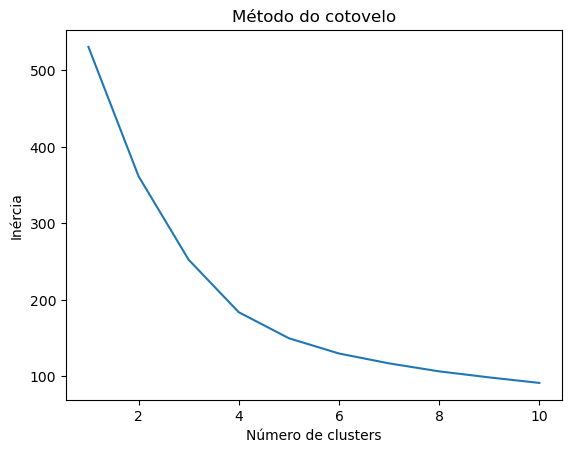

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


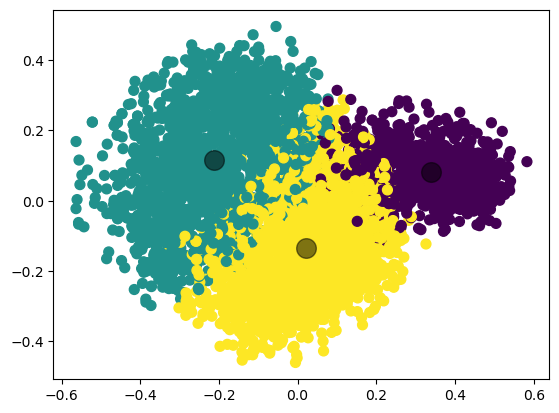

In [16]:
#método do cotovelo para definir o número de clusters

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#lista para armazenar os valores de inércia
inertia = []
#lista para armazenar os valores de k
k = []
#loop para gerar os valores de inércia para cada k
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(df_embeddings_ids_news_pca.iloc[:,:-1].values.tolist())
    inertia.append(kmeans.inertia_)
    k.append(i)
    
#plota o gráfico de cotovelo
plt.plot(k, inertia)
plt.title('Método do cotovelo')
plt.xlabel('Número de clusters')
plt.ylabel('Inércia')
plt.show()

#método da silhueta para definir o número de clusters
kmeans = KMeans(n_clusters = 3, init = 'random')
kmeans.fit(df_embeddings_ids_news_pca.iloc[:,:-1].values.tolist())
y_kmeans = kmeans.predict(df_embeddings_ids_news_pca.iloc[:,:-1].values.tolist())
plt.scatter(df_embeddings_ids_news_pca.iloc[:, 0], df_embeddings_ids_news_pca.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()





6) Avançando na solução e, utilizando os embeddings com três dimensões, elabore uma matriz de similaridades utilizando a equação do cosseno com um limiar maior ou igual a 0.8. Considerando a diagonal superior ou inferior elabore uma rede de notícias, ou seja, para cada par distinto de notícias com similaridade maior ou igual ao limiar devem ser criadas arestas com o respectivo peso (similaridade calculada). Eventualmente o valor do limiar pode ser um pouco menor ou maior de 0.8. A rede deve então ser projetada em que os nós devem ter o seu tamanho definido em função seu valor de centralidade de grau;

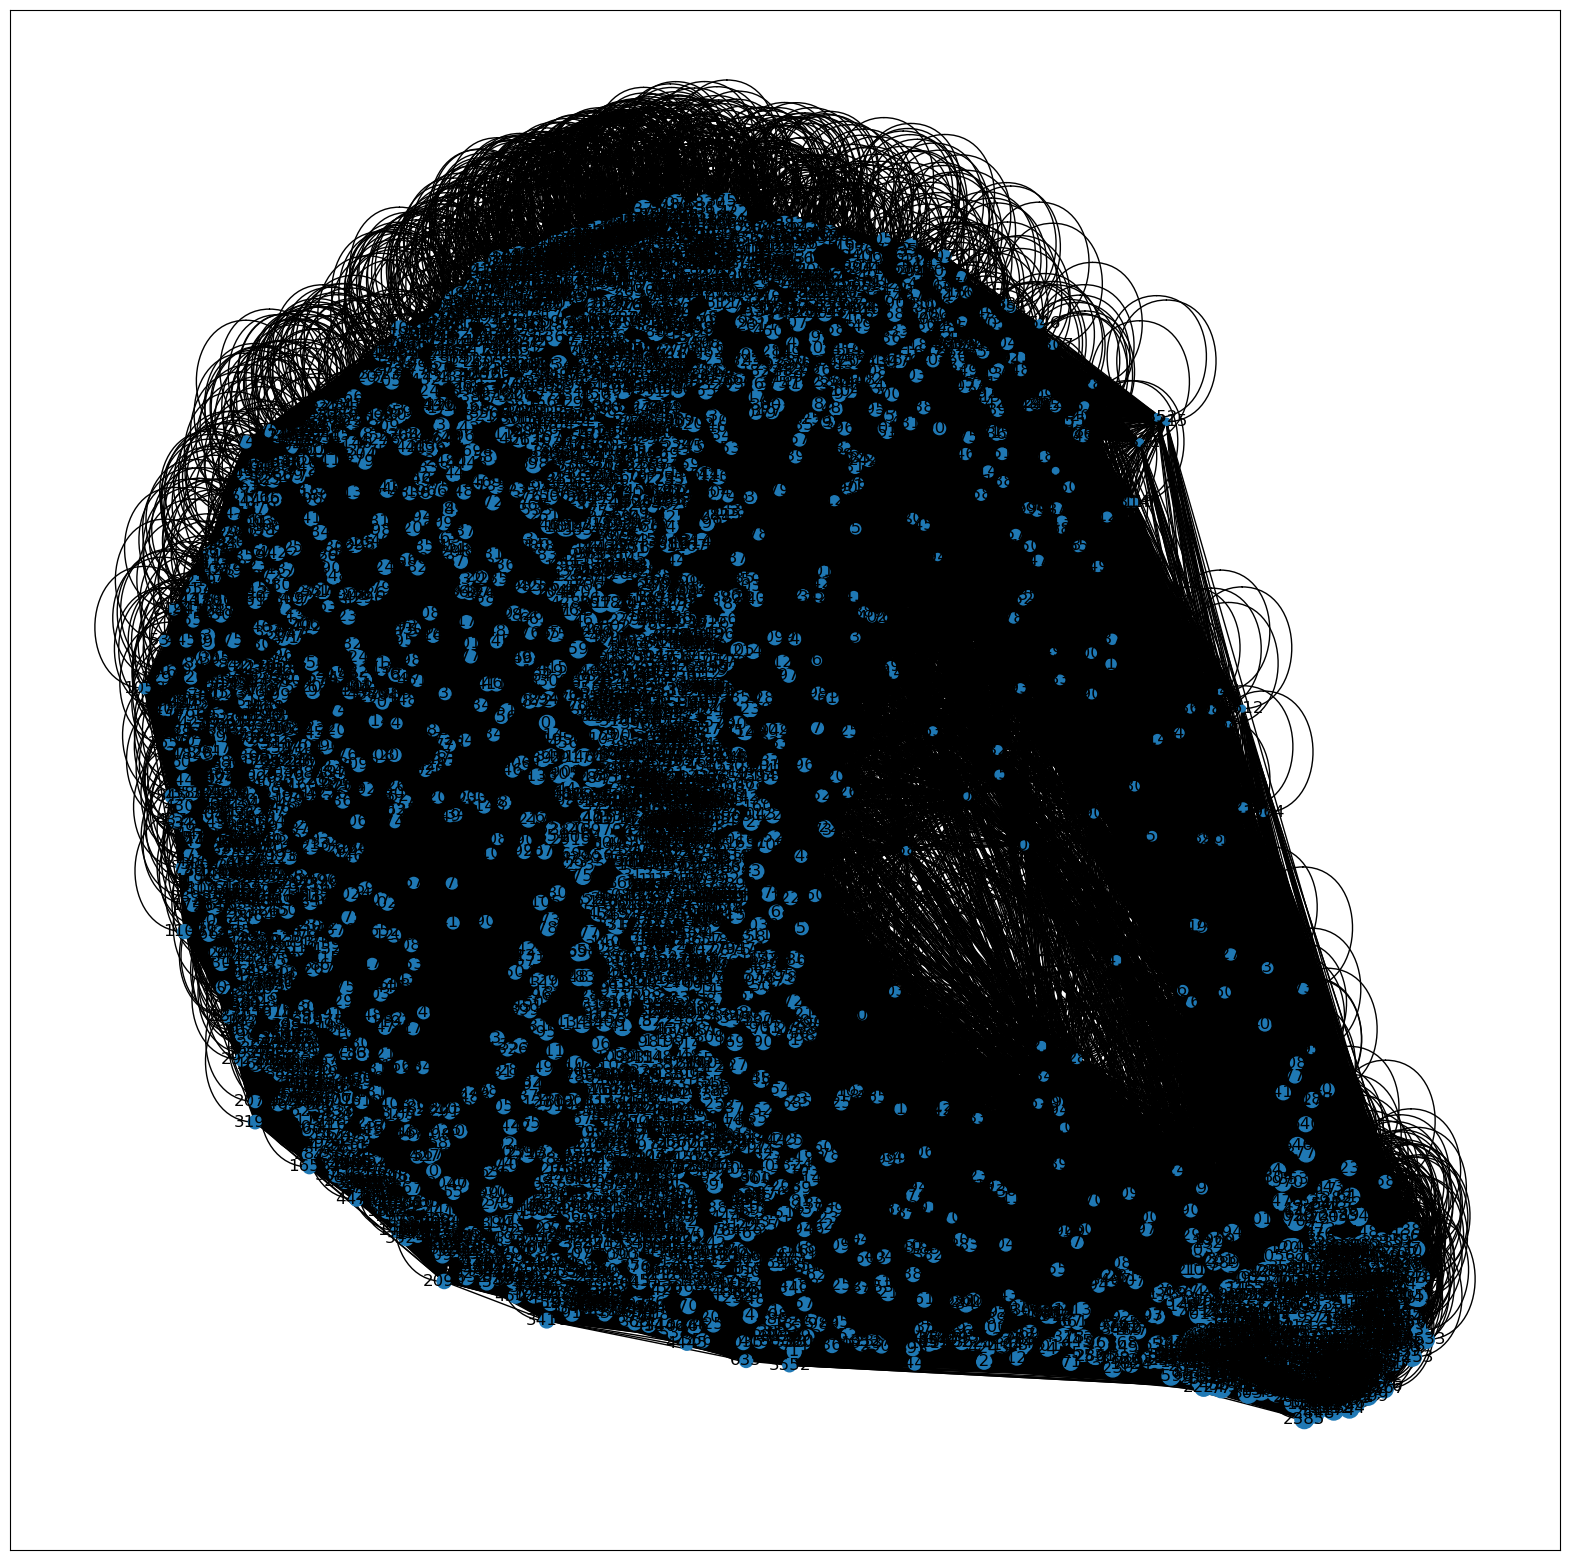

In [17]:
#Avançando na solução e, utilizando os embeddings com três dimensões, elabore uma matriz de similaridades utilizando a equação do cosseno com um limiar maior ou igual a 0.8. Considerando a diagonal superior ou inferior elabore uma rede de notícias, ou seja, para cada par distinto de notícias com similaridade maior ou igual ao limiar devem ser criadas arestas com o respectivo peso (similaridade calculada). Eventualmente o valor do limiar pode ser um pouco menor ou maior de 0.8. A rede deve então ser projetada em que os nós devem ter o seu tamanho definido em função seu valor de centralidade de grau

#cria a matriz de similaridade
from sklearn.metrics.pairwise import cosine_similarity
df_embeddings_ids_news_pca = df_embeddings_ids_news_pca.set_index('id')
df_embeddings_ids_news_pca.head()
df_embeddings_ids_news_pca.shape
#calcula a matriz de similaridade
df_similarity = pd.DataFrame(cosine_similarity(df_embeddings_ids_news_pca))
df_similarity.head()
df_similarity.shape
#cria a rede
G = nx.Graph()
#cria os nós
G.add_nodes_from(df_embeddings_ids_news_pca.index)
#cria as arestas
for i in range(df_similarity.shape[0]):
    for j in range(df_similarity.shape[1]):
        if df_similarity.iloc[i,j] >= 0.8:
            G.add_edge(df_similarity.index[i], df_similarity.columns[j], weight=df_similarity.iloc[i,j])
#calcula a centralidade de grau
degree_centrality = nx.degree_centrality(G)
#calcula o tamanho dos nós
node_size = [v * 1000 for v in degree_centrality.values()]
#plota a rede
plt.figure(figsize=(20,20))
nx.draw_networkx(G, node_size=node_size)
plt.show()

